# CS 273P Final Project Notebook

## Project Topic - Classification of American Sign Language Letters using Convolutional Neural Networks

### Members - Yash Uday Kulkarni, Kenneth Tony Chungath

### This is a Kaggle kernel so it won't be executed on a normal machine. Please fork and run the Kaggle kernel to execute this notebook. 

### Link: https://www.kaggle.com/yashudaykulkarni/model-training

### Link of Model: https://drive.google.com/file/d/1lQdHNOHApjlK2lRdfL0LRSUNYVkqDGmV/view?usp=sharing

In [1]:
!pip install torchsummary

In [2]:
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch import optim, cuda
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchsummary import summary
import seaborn as sns
import torch.nn as nn
import torch
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time 
import pandas as pd
import warnings
import random
warnings.filterwarnings('ignore', category=FutureWarning)
from PIL import Image

In [3]:
gpu_flag = cuda.is_available()
if not gpu_flag:
    print("Please use GPU to run this notebook")

In [4]:
index_to_char_map = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}

In [5]:
#Parameters
dataset_1_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train' #Link: https://www.kaggle.com/grassknoted/asl-alphabet
dataset_2_dir = '../input/asl-alphabet-new-test/asl-alphabet-test' #Link: https://www.kaggle.com/yashudaykulkarni/asl-alphabet-new-test

img_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'

save_file_name_1 = 'vgg_cur_model_transfer_learning_1.pt'
save_file_name_2 = 'vgg_cur_model_transfer_learning_2.pt'

batch_size = 16
lr = 0.001
momentum = 0.9
num_epochs = 5

dataset_1_length = 87000
dataset_2_length = 870

n_classes = 29

train_split_ratio = 0.5
val_split_ratio = 0.25

In [6]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'val':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
def dataloader_lengths(dataset_length, train_split_ratio, val_split_ratio):
    train_split = int(np.floor(train_split_ratio * dataset_length))
    val_split = int(np.floor(val_split_ratio * dataset_length))
    
    train_dataloader_length = train_split
    val_dataloader_length = val_split
    test_dataloader_length = dataset_length-(train_dataloader_length + val_dataloader_length)
    
    return train_dataloader_length, test_dataloader_length, val_dataloader_length

In [8]:
def split_dataset(dataset_length, train_split_length, val_split_length, dataset):
    indices = list(range(dataset_length))
        
    np.random.shuffle(indices)

    train_indices = indices[:train_split_length]
    val_indices = indices[train_split_length:train_split_length+val_split_length]
    test_indices = indices[train_split_length+val_split_length:] 
    
    train_indices_df = pd.DataFrame(train_indices)
    train_indices_df.to_csv('train_indices_' + str(dataset) + '_vals.csv', index=False)
    
    test_indices_df = pd.DataFrame(test_indices)
    test_indices_df.to_csv('test_indices_' + str(dataset) + '_vals.csv', index=False)
    
    val_indices_df = pd.DataFrame(val_indices)
    val_indices_df.to_csv('val_indices_' + str(dataset) + '_vals.csv', index=False)

    return train_indices, test_indices, val_indices

In [9]:
def create_ImageFolder(dataset_dir):
    data = {
        'train': datasets.ImageFolder(root=dataset_dir, transform=image_transforms['train']),
        'val': datasets.ImageFolder(root=dataset_dir, transform=image_transforms['val']),
        'test': datasets.ImageFolder(root=dataset_dir, transform=image_transforms['test']),
    }
    
    return data

In [10]:
def create_sampler(train_indices, test_indices, val_indices):
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    
    return train_sampler, test_sampler, val_sampler

In [11]:
def create_DataLoader(data, train_sampler, test_sampler, val_sampler):
    dataloader = {
        'train': DataLoader(data['train'], batch_size=batch_size, sampler=train_sampler),
        'val': DataLoader(data['val'], batch_size=batch_size, sampler=val_sampler),
        'test': DataLoader(data['test'], batch_size=batch_size, sampler=test_sampler),
    }
    
    return dataloader

In [12]:
def get_model(pretrained):
    if pretrained:
        model = models.vgg16_bn(pretrained=True)
    else:
        model = models.vgg16_bn()
    model.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(p=0.5, inplace=False),
                                     nn.Linear(in_features=4096, out_features=4096, bias=True),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(p=0.5, inplace=False),
                                     nn.Linear(in_features=4096, out_features=29, bias=True)
                                    )
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    model = model.to('cuda')
    return model, criterion, optimizer

In [13]:
def save_model(model, save_file_name):
    torch.save(model.state_dict(), save_file_name)

In [14]:
def train_model(model, train_dataloader, train_dataloader_length, val_dataloader, val_dataloader_length, criterion, optimizer, num_epochs, save_file_name):
    val_loss_min = np.Inf
    
    #Lists to store model stats
    model_train_acc = np.zeros(num_epochs)
    model_val_acc = np.zeros(num_epochs)
    model_train_loss = np.zeros(num_epochs)
    model_val_loss = np.zeros(num_epochs)
    
    begin_time = time.time()
    
    for epoch in range(num_epochs):
        print('Epoch ' + str(epoch))
        
        cur_epoch_train_loss, cur_epoch_val_loss = 0.0, 0.0
        cur_epoch_train_acc, cur_epoch_val_acc = 0, 0
        
        #Set the model to training mode
        model.train()
        
        for features, labels in train_dataloader:
            #Move feature and label tensors on CUDA
            features = features.cuda()
            labels = labels.cuda()
                
            #Calculate output and loss of the model and perform backpropogation
            optimizer.zero_grad()
            output = model(features) 
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            #Calculate training loss and accuracy values for current epoch
            cur_epoch_train_loss += loss.item() * features.size(0)
            _, pred = torch.max(output, dim=1)
            cur_epoch_train_acc += torch.sum(pred == labels.data)
            
            #Empty cache 
            torch.cuda.empty_cache()
            del features, labels, output, pred
        
        model.epochs += 1
        
        with torch.no_grad():
            #Set the model to evaluation mode for calculating validation stats
            model.eval()
            
            for features, labels in val_dataloader:
                #Move feature and label tensors on CUDA
                features = features.cuda()
                labels = labels.cuda()
                
                #Calculate output and loss of the model 
                output = model(features)
                loss = criterion(output, labels)

                #Calculate validation loss and accuracy values for current epoch
                cur_epoch_val_loss += loss.item() * features.size(0)
                _, pred = torch.max(output, dim=1)
                cur_epoch_val_acc += torch.sum(pred == labels.data)
            
                #Empty cache 
                torch.cuda.empty_cache()
                del features, labels, output, pred
                
        # Calculate the training and validation loss and accuracy values 
        cur_epoch_train_loss = cur_epoch_train_loss / train_dataloader_length
        model_train_loss[epoch] = cur_epoch_train_loss

        cur_epoch_val_loss = cur_epoch_val_loss / val_dataloader_length
        model_val_loss[epoch] = cur_epoch_val_loss

        cur_epoch_train_acc = cur_epoch_train_acc.double() / train_dataloader_length
        model_train_acc[epoch] = cur_epoch_train_acc

        cur_epoch_val_acc = cur_epoch_val_acc.double() / val_dataloader_length
        model_val_acc[epoch] = cur_epoch_val_acc

        print('Training Loss - ' + str(round(cur_epoch_train_loss, 2)) + ' Training Accuracy - ' + str(round(cur_epoch_train_acc.item() * 100, 2)) + '%')
        print('Validation Loss - ' + str(round(cur_epoch_val_loss, 2)) + ' Validation Accuracy - ' + str(round(cur_epoch_val_acc.item() * 100, 2)) + '%')
        print('Time elapsed - ' + str(round(time.time() - begin_time, 2)) + ' secs')
        print()

        #Save best model and epoch stats
        if cur_epoch_val_loss < val_loss_min:                
            save_model(model, save_file_name)
            best_epoch = epoch
            val_loss_min = cur_epoch_val_loss
            best_val_acc = cur_epoch_val_acc.double()
    
    total_time = time.time() - begin_time
    
    print('Training Complete!')
    print('Best epoch - ' + str(best_epoch))
    print('Final Validation Loss - ' + str(round(val_loss_min, 4)))
    print('Final Validation Accuracy - ' + str(round(best_val_acc.item() * 100, 2)) + '%')
                    
    return model, model_train_loss, model_train_acc, model_val_loss, model_val_acc

In [15]:
def generate_freq_class_dataloader(dataloader):
    freq_list = np.zeros(29)

    for step, (images, labels) in enumerate(dataloader):
        for label in labels:
            freq_list[label] += 1
        del images, labels

    return freq_list

In [16]:
def eval_model(test_dataloader, test_dataloader_length, freq_list):
    test_loss = 0.0
    test_acc = 0.0
    
    acc_every_class = np.zeros(29)
        
    for features, labels in test_dataloader:
        #Set the model to evaluation mode for calculating testing stats
        model.eval()
        
        #Move feature and label tensors on CUDA
        features = features.cuda()
        labels = labels.cuda()
            
        #Calculate output and loss of the model 
        output = model(features)
        loss = criterion(output, labels)
        
        #Calculate testing loss and accuracy values for current epoch
        test_loss += loss.item() * features.size(0)
        _, pred = torch.max(output, dim=1)
        test_acc += torch.sum(pred == labels.data)
        
        #Calculate the accuracy per class of the dataset for model
        for i, (p, label) in enumerate(zip(pred, labels)):
            acc_every_class[label] += (pred[i] == labels[i])
        
        #Empty cache 
        torch.cuda.empty_cache()
        del features, labels, output, pred
    
    # Calculate the testing loss and accuracy values 
    test_acc = test_acc.double() / test_dataloader_length
    test_loss = test_loss / test_dataloader_length
    
    for i in range(len(acc_every_class)):
        acc_every_class[i] = acc_every_class[i] / freq_list[i]
        
    return test_acc, test_loss, acc_every_class

## Set up ImageFolder and DataLoader of training, testing and validation sets of Datasets 1 and 2

In [17]:
train_dataloader_1_length, test_dataloader_1_length, val_dataloader_1_length = dataloader_lengths(dataset_1_length, train_split_ratio, val_split_ratio)

In [18]:
train_dataloader_2_length, test_dataloader_2_length, val_dataloader_2_length = dataloader_lengths(dataset_2_length, train_split_ratio, val_split_ratio)

In [19]:
train_indices_1, test_indices_1, val_indices_1 = split_dataset(dataset_1_length, train_dataloader_1_length, val_dataloader_1_length, 1)

In [20]:
train_indices_2, test_indices_2, val_indices_2 = split_dataset(dataset_2_length, train_dataloader_2_length, val_dataloader_2_length, 2)

In [21]:
train_sampler_1, test_sampler_1, val_sampler_1 = create_sampler(train_indices_1, test_indices_1, val_indices_1)

In [22]:
train_sampler_2, test_sampler_2, val_sampler_2 = create_sampler(train_indices_2, test_indices_2, val_indices_2)

In [23]:
data_1 = create_ImageFolder(dataset_1_dir)

In [24]:
data_2 = create_ImageFolder(dataset_2_dir)

In [25]:
dataloader_1 = create_DataLoader(data_1, train_sampler_1, test_sampler_1, val_sampler_1)

In [26]:
dataloader_2 = create_DataLoader(data_2, train_sampler_2, test_sampler_2, val_sampler_2)

## Train the pre-trained model for 5 epochs on Dataset 1

In [29]:
model, criterion, optimizer = get_model(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [30]:
model.epochs = 0

In [31]:
model, model_train_loss_1, model_train_acc_1, model_val_loss_1, model_val_acc_1 = train_model(model, dataloader_1['train'], train_dataloader_1_length, dataloader_1['val'], val_dataloader_1_length, criterion, optimizer, num_epochs, save_file_name_1)

Epoch 0
Training Loss - 0.56 Training Accuracy - 84.21%
Validation Loss - 0.03 Validation Accuracy - 99.4%
Time elapsed - 978.25 secs

Epoch 1
Training Loss - 0.01 Training Accuracy - 99.82%
Validation Loss - 0.0 Validation Accuracy - 99.96%
Time elapsed - 1838.91 secs

Epoch 2
Training Loss - 0.0 Training Accuracy - 99.91%
Validation Loss - 0.0 Validation Accuracy - 100.0%
Time elapsed - 2702.39 secs

Epoch 3
Training Loss - 0.0 Training Accuracy - 99.96%
Validation Loss - 0.0 Validation Accuracy - 99.86%
Time elapsed - 3582.11 secs

Epoch 4
Training Loss - 0.0 Training Accuracy - 99.96%
Validation Loss - 0.0 Validation Accuracy - 99.99%
Time elapsed - 4455.94 secs

Training Complete!
Best epoch - 4
Final Validation Loss - 0.0003
Final Validation Accuracy - 99.99%


## Plot epochs vs Training and Validation Losses for Dataset 1

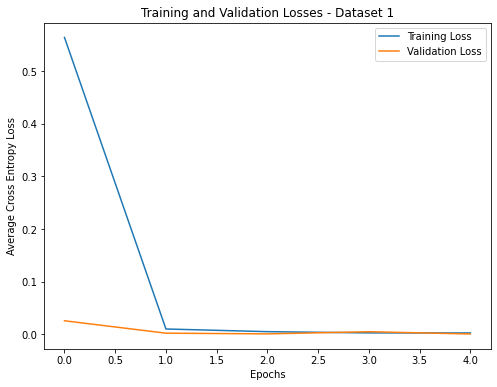

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(model_train_loss_1, label='Training Loss')
plt.plot(model_val_loss_1, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Cross Entropy Loss')
plt.title('Training and Validation Losses - Dataset 1')
plt.savefig('loss_graph.png')

## Plot epochs vs Training and Validation Accuracy for Dataset 1

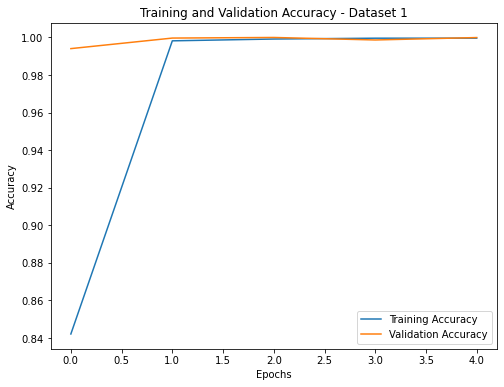

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(model_train_acc_1, label='Training Accuracy')
plt.plot(model_val_acc_1, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - Dataset 1')
plt.savefig('accuracy_graph.png')

## Evaluate the model on testing set of Dataset 1

In [34]:
freq_list_test_1 = generate_freq_class_dataloader(dataloader_1['test'])

In [35]:
test_acc_1, test_loss_1, acc_every_class_1 = eval_model(dataloader_1['test'], test_dataloader_1_length, freq_list_test_1)

### Accuracy and Losses of model on testing set of Dataset 1

In [36]:
print(test_acc_1.item() * 100, test_loss_1)

99.99540229885058 0.00028696253107882093


### Accuracy of every class of Dataset 1 by model on testing set of Dataset 1

In [37]:
print(acc_every_class_1 * 100)

[100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.          99.86282579 100.         100.        ]


## Evaluate the model on testing set of Dataset 2

In [38]:
freq_list_test_2 = generate_freq_class_dataloader(dataloader_2['test'])

In [39]:
test_acc_2, test_loss_2, acc_every_class_2 = eval_model(dataloader_2['test'], test_dataloader_2_length, freq_list_test_2)

### Accuracy and Losses of model on testing set of Dataset 2

In [40]:
print(test_acc_2.item() * 100, test_loss_2)

55.5045871559633 3.408568880973606


### Accuracy of every class of Dataset 1 by model on testing set of Dataset 2

In [41]:
print(acc_every_class_2 * 100)

[ 22.22222222  25.           0.          77.77777778  25.
  57.14285714   0.         100.          42.85714286  88.88888889
 100.         100.          55.55555556  77.77777778  50.
 100.         100.          57.14285714  25.           0.
  55.55555556  37.5        100.          44.44444444 100.
  50.          55.55555556  20.         100.        ]


## Train the pre-trained model for 5 epochs on Dataset 2

In [42]:
model, model_train_loss_2, model_train_acc_2, model_val_loss_2, model_val_acc_2 = train_model(model, dataloader_2['train'], train_dataloader_2_length, dataloader_2['val'], val_dataloader_2_length, criterion, optimizer, num_epochs, save_file_name_2)

Epoch 0
Training Loss - 0.59 Training Accuracy - 83.22%
Validation Loss - 0.43 Validation Accuracy - 86.64%
Time elapsed - 9.93 secs

Epoch 1
Training Loss - 0.2 Training Accuracy - 94.48%
Validation Loss - 0.28 Validation Accuracy - 93.55%
Time elapsed - 19.51 secs

Epoch 2
Training Loss - 0.12 Training Accuracy - 96.32%
Validation Loss - 0.25 Validation Accuracy - 91.71%
Time elapsed - 29.39 secs

Epoch 3
Training Loss - 0.04 Training Accuracy - 98.85%
Validation Loss - 0.18 Validation Accuracy - 94.01%
Time elapsed - 39.27 secs

Epoch 4
Training Loss - 0.03 Training Accuracy - 99.54%
Validation Loss - 0.14 Validation Accuracy - 94.93%
Time elapsed - 49.14 secs

Training Complete!
Best epoch - 4
Final Validation Loss - 0.1378
Final Validation Accuracy - 94.93%


## Plot epochs vs Training and Validation Losses for Dataset 2

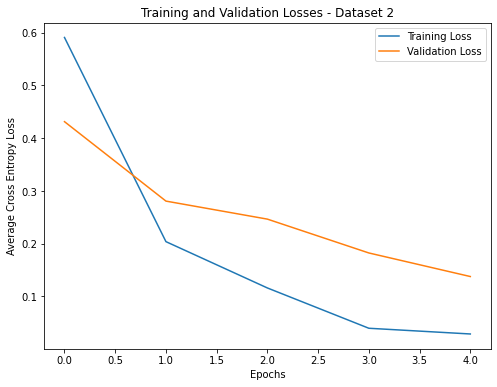

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(model_train_loss_2, label='Training Loss')
plt.plot(model_val_loss_2, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Cross Entropy Loss')
plt.title('Training and Validation Losses - Dataset 2')
plt.savefig('loss_graph_new_dataset.png')

## Plot epochs vs Training and Validation Accuracy for Dataset 2

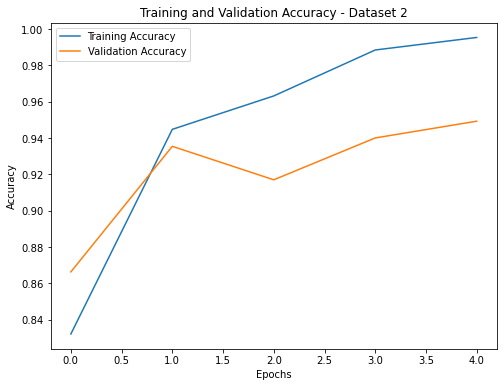

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(model_train_acc_2, label='Training Accuracy')
plt.plot(model_val_acc_2, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - Dataset 2')
plt.savefig('accuracy_graph_new_dataset.png')

## Evaluate the model on testing set of Dataset 2

In [45]:
test_acc_2, test_loss_2, acc_every_class_2 = eval_model(dataloader_2['test'], test_dataloader_2_length, freq_list_test_2)

### Accuracy and Losses of model on testing set of Dataset 2

In [46]:
print(test_acc_2.item() * 100, test_loss_2)

92.66055045871559 0.24745388971556218


### Accuracy of every class of Dataset 2 by model on testing set of Dataset 2

In [47]:
print(acc_every_class_2 * 100)

[ 88.88888889 100.         100.         100.         100.
  57.14285714  90.         100.         100.         100.
  75.         100.          66.66666667  88.88888889  90.
 100.         100.         100.          62.5        100.
  77.77777778 100.         100.         100.         100.
 100.         100.         100.         100.        ]
